In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import warnings; warnings.simplefilter('ignore')
import fitsio
from astropy.table import Table

from main_def import search_around, flux_to_mag, cut
from geometric_def import query_catalog_mask, LSLGA_fit, LSLGA_veto, circular_mask_radii_func


# Overview

This notebook intends to revisited the cut on Fibre Magnitude carried at `/global/homes/q/qmxp55/DESI/BGS_paper/fibmag.ipynb` notebook. From that analysis we agreed that the best cut to avoid galaxies with very low brighness surface was at,

    FMC: 2.9 + rmag

This cut was stablish using the data we previously inspected by eye (~5000 objects) to revisited the `FRACS*` cuts. In that case our based catalogue was of around `1400` deg$^2$, but in this case our starting up catalogue is the `180 < RA < 200` and `5 < DEC < 15` patch of `~200` deg$^2$, and `rmag < 20`. This catalogue contains all of this from the SWEEPS and it also contain a column of arrays called `CUTS` where if not empty the array points out which BGS mask (or masks) was applied to this object. 

Within this notebook we can switch between two catalogues with the same footprint but with the only difference that one uses `Kyle's radii` to mask around Bright Stars and the other uses `Dustin's radii`.

# Sample catalogue #1

For this notebook we're going to use one of the output catalogues from the BGS pipeline that includes the masking column `CUTS`. More expecifications of the catalogue below:
    
    dr = dr7
    (180 < RA < 200) & (5 < DEC < 15)
    rmag < 20
    
    ----- CUTS column key -----
    0 = Bright Star: Kyle radii
    1 = Large Galaxy:major=D25/2
    2 = NOBS
    3 = ALLMASK
    4 = Star-Galaxy separation
    5 = Fibre Magnitude Cut
    6 = Colour Cuts
    7 = FRACS* 

In [2]:
path1 = '/global/homes/q/qmxp55/DESI/BGS_paper/dr7_180_200_5_15_rmag_20_N_2/kyle_Lkyle_Wkyle_D25_1_0_1_gaia_gal_2.9_-1_4_0.4_0.3_5_0/'
BGS = np.load(path1+'BGS_cat.npy')
BGS_ran = np.load(path1+'randoms_cat.npy')

# Sample catalogue #2

For this notebook we're going to use one of the output catalogues from the BGS pipeline that includes the masking column `CUTS`. More expecifications of the catalogue below:
    
    dr = dr8
    (134 < RA < 139) & (32 < DEC < 34)
    rmag < 20
    
    ----- CUTS column key -----
    0 = Bright Star: Dustin’s radii
    1 = Medium Star
    2 = Globular Cluster
    3 = Large Galaxy:major=D25/2
    4 = NOBS
    5 = ALLMASK
    6 = Star-Galaxy separation
    7 = Fibre Magnitude Cut
    8 = Colour Cuts
    9 = FRACS* 
    

In [3]:
#path1 = '/global/homes/q/qmxp55/DESI/BGS_paper/dr8c_v3.0_134_139_32_34_rmag_20_N_2/'
#BGS = np.load(path1+'BGS_cat.npy')

# Define params...

In [4]:
gaia = BGS['GAIA_PHOT_G_MEAN_MAG'] != 0
CUTOUT = BGS['CUTS'] != ''
#MS = BGS['CUTS'] == '1' #MS only
rmag = flux_to_mag(BGS['FLUX_R']/BGS['MW_TRANSMISSION_R'])
bright = rmag < 19.5
faint = rmag > 19.5
PSF = BGS['TYPE'] == 'PSF '
fibmag = flux_to_mag(BGS['FIBERFLUX_R']/BGS['MW_TRANSMISSION_R'])

layer_dr7='decals-dr7'
layer_dr8='r8c-decam'

In [5]:
#CUTOUT_ran = BGS_ran['CUTS'] != ''

In [6]:
#SGS = BGS['CUTS'] == '4' #Star-Galaxy only: dr7

In [7]:
def allinCut(ref):
    
    cut = np.zeros(len(BGS), dtype='?')
    for i in set(BGS['CUTS']):
        if ref in i:
            cut |= BGS['CUTS'] == i
            
    return cut

In [8]:
#Some cuts in DR7...
SGT = allinCut(ref='4')
LGT = allinCut(ref='1')
BST = allinCut(ref='0')

In [9]:
ramin, ramax, decmin, decmax = BGS['RA'].min(), BGS['RA'].max(), BGS['DEC'].min(), BGS['DEC'].max()

In [10]:
#Loading Tycho2 catalogue
path = '/global/homes/q/qmxp55/DESI/matches/'
tycho_ = fitsio.read(path+'tycho2.fits')
#cutting out to the same footprint as DECaLS catalogue
tycho = cut(ramin, ramax, decmin, decmax, tycho_)

In [11]:
#Loading the Legacy Survey Large Galaxy Atlas (href: https://github.com/moustakas/LSLGA)
LSLGA_ = fitsio.read('/global/project/projectdirs/desi/users/qmxp55/matches/LSLGA-v2.0.fits')
#cutting out to the same footprint as DECaLS catalogue
LSLGA = cut(ramin, ramax, decmin, decmax, LSLGA_)
#we have some nan's in PA (galaxy declination/angle) that end up with no ellipses in the postages...
masknans = (~np.isnan(LSLGA['PA'])) & (~np.isnan(LSLGA['BA'])) & (~np.isnan(LSLGA['D25']))
#replace nan's with zeroes
LSLGA['PA'][np.where(~masknans)] = 0
#LSLGA = LSLGA[masknans]

# FMC rejecting LG?

The main reason of the revisiting of FMC is because we've found that this particular cut is rejecting LSLGA galaxies. Here we are gonna get the number of LSLGA galaxies that are being rejected not only by  FMC but all other cuts and get some examples with the postages only for FMC rejections...

In [12]:
#Matching all LSLGA galaxies with catalogue (remember, the catalogue is called BGS but it cotains everything...)
def LSLGAinCut(cut_id='5'):
    
    #key for DR7
    key = {'0':'BS', '1':'LG', '2':'NOBS', '3':'ALLMASK', '4':'SGS', '5':'FMC', '6':'CC', '7':'FRACS*'}
    
    idx2, idx1, d2d, d_ra, d_dec = search_around(LSLGA['RA'], LSLGA['DEC'], BGS['RA'], 
                                             BGS['DEC'], search_radius=0.1)
    
    inFMCidx = []
    for i in idx1:
        if cut_id in BGS['CUTS'][i]: #for dr7
        #if '7' in BGS['CUTS'][i]: #for dr8
            inFMCidx.append(i)
    
    print('%d LSLGA out of %d are being rejected by %s too --> %2.3g %%' %(len(inFMCidx), len(idx1), key[cut_id], 100*(len(inFMCidx)/len(idx1))))
    print('-------------------------')
    
    major = np.zeros(len(BGS), float)
    minor = np.zeros(len(BGS), float)
    angle = np.zeros(len(BGS), float)

    #major[idx1] = LSLGA['D25'][idx2]/2./60. #major in DR8
    major[idx1] = LSLGA['D25'][idx2]/60. #major in DR7 -- twice as DR8
    minor[idx1] = major[idx1]*LSLGA['BA'][idx2]
    angle[idx1] = 90 - LSLGA['PA'][idx2]
    
    radius_LG = np.array([major, minor, angle]).T
    
    return np.array(inFMCidx), radius_LG

In [13]:
inBSidx, rad_BS = LSLGAinCut(cut_id='0')
inLGidx, rad_LG = LSLGAinCut(cut_id='1')
inNOBSidx, rad_NOBS = LSLGAinCut(cut_id='2')
inALLMASKidx, rad_ALLMASK = LSLGAinCut(cut_id='3')
inSGSidx, rad_SGS = LSLGAinCut(cut_id='4')
inFMCidx, rad_FMC = LSLGAinCut(cut_id='5')
inCCidx, rad_CC = LSLGAinCut(cut_id='6')
inQCidx, rad_QC = LSLGAinCut(cut_id='7')

1094 nearby objects ~ 0.154165 %
4 LSLGA out of 1094 are being rejected by BS too --> 0.366 %
-------------------------
1094 nearby objects ~ 0.154165 %
1094 LSLGA out of 1094 are being rejected by LG too --> 100 %
-------------------------
1094 nearby objects ~ 0.154165 %
3 LSLGA out of 1094 are being rejected by NOBS too --> 0.274 %
-------------------------
1094 nearby objects ~ 0.154165 %
6 LSLGA out of 1094 are being rejected by ALLMASK too --> 0.548 %
-------------------------
1094 nearby objects ~ 0.154165 %
2 LSLGA out of 1094 are being rejected by SGS too --> 0.183 %
-------------------------
1094 nearby objects ~ 0.154165 %
336 LSLGA out of 1094 are being rejected by FMC too --> 30.7 %
-------------------------
1094 nearby objects ~ 0.154165 %
3 LSLGA out of 1094 are being rejected by CC too --> 0.274 %
-------------------------
1094 nearby objects ~ 0.154165 %
30 LSLGA out of 1094 are being rejected by FRACS* too --> 2.74 %
-------------------------


Central coords in postage: RA:193.740283007793, DEC:10.685506392525, Cidx:691307, rad:25
Central coords in postage: RA:194.434373745350, DEC:10.051863046879, Cidx:574176, rad:22
Central coords in postage: RA:183.870902012370, DEC:7.834999404657, Cidx:67079, rad:21
Central coords in postage: RA:180.126393096136, DEC:9.972428101851, Cidx:104502, rad:24
Central coords in postage: RA:187.474563469641, DEC:10.338011567551, Cidx:179367, rad:45
Central coords in postage: RA:191.314254206360, DEC:7.615686670012, Cidx:433064, rad:32


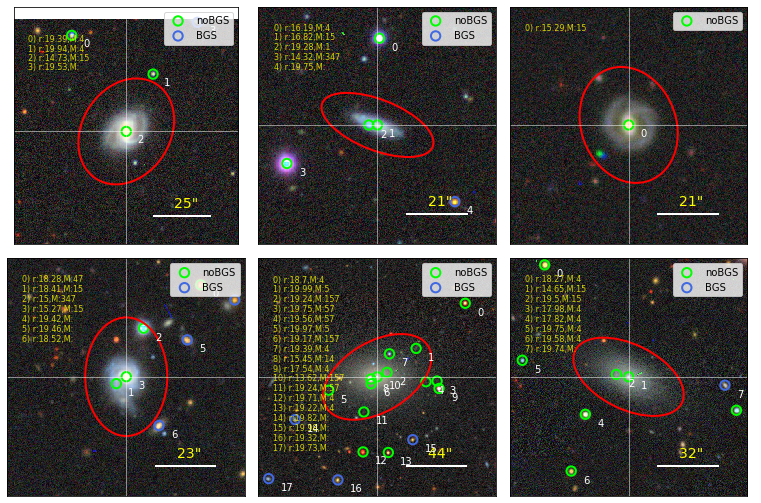

In [18]:
veto = {'noBGS':CUTOUT, 'BGS':~CUTOUT}
info = {'r':rmag,'M':BGS['CUTS']}

postages_circle(coord=[BGS['RA'], BGS['DEC']], centeridx=inFMCidx, veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer_dr7, radius=rad_FMC, m=2, grid=[2,3], 
                savefile=None, layer2=None, layer2Mode='separate', isLG=True)

## Total Mag Vs Fibre mag of LSLGA galaxies rejected by FMC...

COMPLETENESS: 99.9991 %


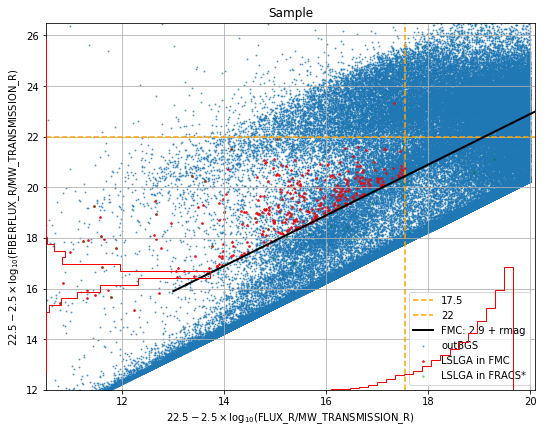

In [19]:
limit = [10.5, 20.1, 12, 26.5]
frac_density(pars=[rmag[CUTOUT], fibmag[CUTOUT], None ], pars2=[rmag[inFMCidx], fibmag[inFMCidx]], pars3=[rmag[inQCidx], fibmag[inQCidx]], 
             par_lab=['outBGS', 'LSLGA in FMC', 'LSLGA in FRACS*'], title='Sample', log=False, plot='scatter', limit=limit)

The rejection of LSLGA galaxies by FMC is not a problem by itself -we can recover/bring back this galaxies with the `REF` parameter in DR8- but  what about the galaxies that aren’t in LSLGA and are being threatened by FMC?

The LSLGA galaxies rejected by the FMC cut stop at rmag of ~17.5 and at fibmag of ~22 (with the exception of one galaxy at fibmag 23.3). We are going to take these limits to eye inspect the rejected objects with the postages but instead of looking to all the rejected objects we are going to ignore the rejected by the `Star-Galaxy separation cut` since is one of the most trustables -only Stars here- and the vast majority of the rejected objects come from this mask. Also, since we don't want to meet with any `LSLGA galaxy` or `Bright Star`, we are going to ignore the LG and BS cuts. We propose to do the eye inspection of small evenly separated (in fibmag) cells within a main slice:

    Main slice:
        fibmag < 22
        fibmag > 2.9 + rmag -- above current FMC thresshold
        
    Small cells:
        fibmag < 2.9 + rmag + dy[i+1]
        fibmag > 2.9 + rmag + dy[i]
        fibmag < 22
        rmag < dy[i+1]
        rmag > dy[i]
        
    Where: 
    
    dy = [0, 0.4, 1.2, 2.0, 6.1]
    dx = [13, 22-(2.9+dy[3]), 22-(2.9+dy[2]), 22-(2.9+dy[1]), 19.1]
   

In [48]:
def get_cells(plot=False, savefile=False, Omask=None):
    
    import itertools
    
    cells = Table()
    dy = [0, 0.4, 1.2, 2.0, 6.1]
    dx = [13, 22-(2.9+dy[3]), 22-(2.9+dy[2]), 22-(2.9+dy[1]), 19.1]
    
    MASK_2 = (CUTOUT) & (~SGT) & (~BST) & (~LGT) #Objects not rejected by SG, BS and LG
    MASK_MAIN = (MASK_2) & (fibmag < 22) & (fibmag > 2.9 + rmag)
    
    print('Total rejected objects by BGS cuts (including STARS): %d --> %2.3g %% out of total in SWEEPS' 
          %(np.sum(CUTOUT), 100*np.sum(CUTOUT)/len(BGS)))
    print('Total galaxies rejected by BGS cuts (excluding STARS): %d --> %2.3g %% out of total rejected by BGS (including STARS)' 
          %(np.sum((CUTOUT) & (~SGT)), 100*np.sum((CUTOUT) & (~SGT))/np.sum(CUTOUT)))
    print('Total galaxies rejected by BGS cuts but BS and LG (excluding STARS): %d --> %2.3g %% out of total rejected by BGS (including STARS)' 
          %(np.sum(MASK_2), 100*np.sum(MASK_2)/np.sum(CUTOUT)))
    print('Total galaxies rejected by BGS cuts but BS and LG (excluding STARS) in Main Patch: %d --> %2.3g %% out of total rejected by BGS but BS and LG(excluding  STARS)' 
          %(np.sum(MASK_MAIN), 100*np.sum(MASK_MAIN)/np.sum(MASK_2)))
    
    for i,j in itertools.product(range(len(dx)-1), range(len(dy)-1)):
        
        MASK = np.ones(len(BGS), bool)
        MASK &= MASK_2
        MASK &= (rmag < dx[i+1]) & (rmag > dx[i])
        MASK &= (fibmag > 2.9 + rmag + dy[j]) & (fibmag < 2.9 + rmag + dy[j+1])
        MASK &= (fibmag < 22.)
        
        if np.sum(MASK) == 0:
            continue
        
        cell_label = '%i%i' %(i, j)
        cells[cell_label] = MASK
        
        if savefile:
            
            cells_data = Table()
            
            cells_data['idx'] = np.where(MASK)[0]
            cells_data['RA'] = BGS['RA'][MASK]
            cells_data['DEC'] = BGS['DEC'][MASK]
            
            #print(len(BGS['RA'][MASK]), len(BGS['DEC'][MASK]), len(np.where(MASK)[0]))
            cells_data.write('eyeballing_FMC/'+cell_label+'.txt', format='csv')
            del cells_data
    
    print('%d cells found in main patch' %(len(cells.colnames)))
        
    if plot:
        
        plt.figure(figsize=(10,6))
        
        plt.scatter(rmag[MASK_2], fibmag[MASK_2], s=0.3, alpha=0.4, color='gray')
        for i,j in enumerate(cells.colnames):
            finCell = 100*np.sum(cells[j])/np.sum(MASK_2)
            if Omask is not None:
                f_OmaskInCell = 100*np.sum((cells[j]) & (Omask))/np.sum(cells[j])
                if f_OmaskInCell >= 50.:
                    color='darkgreen'
                elif (f_OmaskInCell < 50.) & (f_OmaskInCell >= 25.):
                    color='gold'
                else:
                    color='red'
                    
                plt.scatter(rmag[(cells[j]) & (Omask)], fibmag[(cells[j]) & (Omask)], s=2, color=color, label='%s, N=%d, f=%2.3g' %(j, np.sum(cells[j]), f_OmaskInCell))
            else:
                plt.scatter(rmag[cells[j]], fibmag[cells[j]], s=5, label='%s, N=%d, f=%2.3g' %(j, np.sum(cells[j]), finCell))
        
        for i in dx:
            N2 = 3
            y2= np.linspace(i+2.9, 22, N2)
            plt.plot(np.full(N2, i), y2, color='red', alpha=0.5)
        for i in dy:
            x2= np.linspace(dx[0], 22-(2.9+i), N2)
            plt.plot(x2, 2.9 + x2 + i, color='red', alpha=0.5)
            
        x = np.linspace(dx[0], 22. - 2.9, 4)
        plt.plot(x, x*0+22., color='red', alpha=0.5)
        
        x = np.linspace(dx[0], 21, 10)
        #plt.axhline(22, lw=2, color='red')
        plt.plot(x, 2.9 + x, lw=2, color='k', label='FMC: 2.9 + rmag')
            
        #New FMC cut
        x_N1 = np.linspace(dx[0], 17.1, 4)
        plt.plot(x_N1, 2.9 + 1.2 + x_N1, color='k', ls='--', lw=2)
        x_N2 = np.linspace(17.1, 18.3, 4)
        plt.plot(x_N2, x_N2*0.+21.2, color='k', ls='--', lw=2)
        x_N3 = np.linspace(18.3, 20.1, 4)
        plt.plot(x_N3, 2.9 + x_N3, color='k', ls='--', lw=2)
        
        plt.xlim(10, 20.1)
        plt.ylim(12, 26.5)
        plt.legend()
        plt.grid()
        plt.ylabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %('FIBERFLUX_R', 'MW_TRANSMISSION_R'))
        plt.xlabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %('FLUX_R', 'MW_TRANSMISSION_R'))
    
    return cells


Total rejected objects by BGS cuts (including STARS): 435902 --> 61.4 % out of total in SWEEPS
Total galaxies rejected by BGS cuts (excluding STARS): 64930 --> 14.9 % out of total rejected by BGS (including STARS)
Total galaxies rejected by BGS cuts but BS and LG (excluding STARS): 32369 --> 7.43 % out of total rejected by BGS (including STARS)
Total galaxies rejected by BGS cuts but BS and LG (excluding STARS) in Main Patch: 5264 --> 16.3 % out of total rejected by BGS but BS and LG(excluding  STARS)
10 cells found in main patch


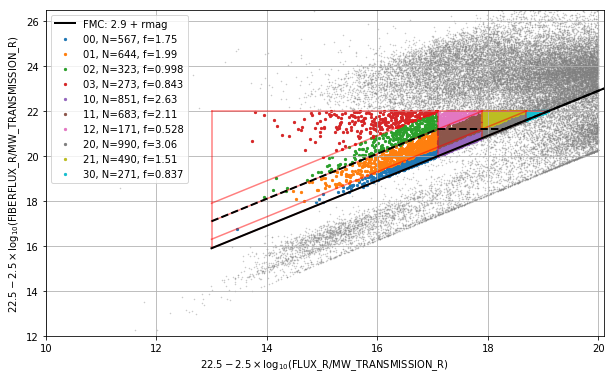

In [49]:
cells = get_cells(plot=True, savefile=False, Omask=None)

## Get eyeballing results...

In [22]:
import glob
import pandas as pd

sample_good = np.zeros(len(BGS), bool)
sample_bad = np.zeros(len(BGS), bool)

sample_good_list = glob.glob("eyeballing_FMC/*good.txt")

j1, j2 = 0, 0
for i in sample_good_list:
    
    #print(i)
    
    file = pd.read_csv(i, sep="\t") 
    file.columns = ["idx","ra", "dec", "good"]
    idx_good = file['idx'][file['good']]
    idx_bad = file['idx'][~file['good']]
    
    print('total in file', i, ':', len(file), ', good:' ,len(idx_good), ', bad' ,len(idx_bad))
    j1 += len(idx_good)
    j2 += len(idx_bad)
    sample_good[np.array(idx_good)] = True
    sample_bad[np.array(idx_bad)] = True
    
print('total good: %d, total bad: %d' %(j1, j2))
print('total in created data, good: %d, bad: %d' %(np.sum(sample_good), np.sum(sample_bad)))

total in file eyeballing_FMC/12_good.txt : 170 , good: 19 , bad 151
total in file eyeballing_FMC/03_good.txt : 272 , good: 3 , bad 269
total in file eyeballing_FMC/20_good.txt : 989 , good: 257 , bad 732
total in file eyeballing_FMC/02_good.txt : 322 , good: 96 , bad 226
total in file eyeballing_FMC/01_good.txt : 643 , good: 420 , bad 223
total in file eyeballing_FMC/10_good.txt : 850 , good: 489 , bad 361
total in file eyeballing_FMC/30_good.txt : 270 , good: 44 , bad 226
total in file eyeballing_FMC/21_good.txt : 489 , good: 79 , bad 410
total in file eyeballing_FMC/11_good.txt : 682 , good: 245 , bad 437
total in file eyeballing_FMC/00_good.txt : 566 , good: 458 , bad 108
total good: 2110, total bad: 3143
total in created data, good: 2110, bad: 3143


Total rejected objects by BGS cuts (including STARS): 435902 --> 61.4 % out of total in SWEEPS
Total galaxies rejected by BGS cuts (excluding STARS): 64930 --> 14.9 % out of total rejected by BGS (including STARS)
Total galaxies rejected by BGS cuts but BS and LG (excluding STARS): 32369 --> 7.43 % out of total rejected by BGS (including STARS)
Total galaxies rejected by BGS cuts but BS and LG (excluding STARS) in Main Patch: 5264 --> 16.3 % out of total rejected by BGS but BS and LG(excluding  STARS)
10 cells found in main patch


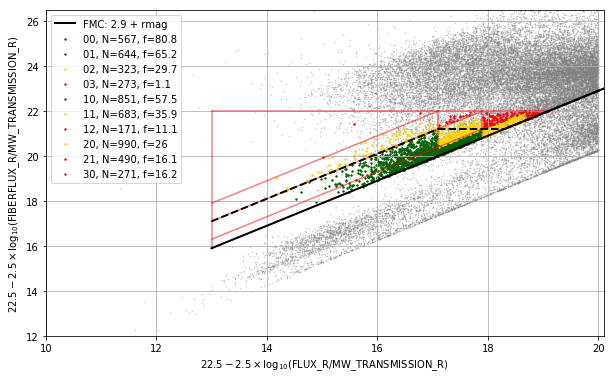

In [50]:
_ = get_cells(plot=True, savefile=False, Omask=sample_good)

The new FMC based on the eye-inspected objects is:

$$FMC = fibmag < (2.9 + 1.2) + rmag  \hspace{3 mm}\& \hspace{3 mm} rmag < 17.1$$
$$FMC \hspace{3 mm} |= fibmag < 21.2 \hspace{3 mm} \& \hspace{3 mm} rmag < 18.3 \hspace{3 mm} \& \hspace{3 mm} rmag > 17.1$$
$$FMC \hspace{3 mm} |= 2.9 + rmag \hspace{3 mm} \& \hspace{3 mm} rmag > 18.3$$

COMPLETENESS: 100 %


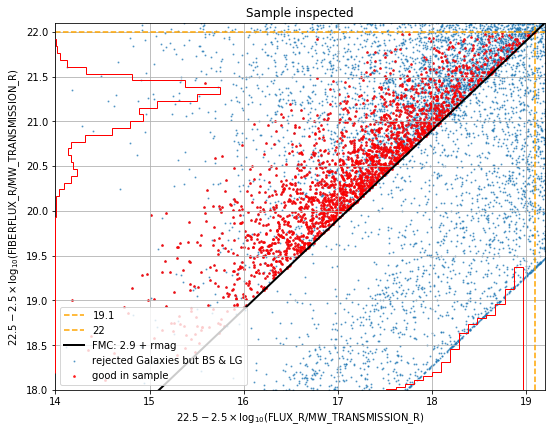

In [24]:
limit = [14, 19.2, 18, 22.1]
sample = (CUTOUT) & (~SGT) & (~BST) & (~LGT)
#pars2=[rmag[sample_bad], fibmag[sample_bad]]
frac_density(pars=[rmag[sample], fibmag[sample], None ], pars2=[rmag[sample_good], fibmag[sample_good]], pars3=None, 
             par_lab=['rejected Galaxies but BS & LG', 'good in sample'], title='Sample inspected', log=False, plot='scatter', limit=limit)

Text(0.5, 0, 'rmag')

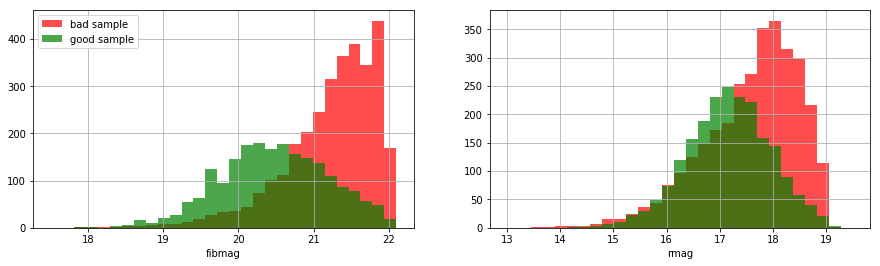

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))

bins_fib = np.linspace(17.5, 22.1, 30)
ax1.hist(fibmag[sample_bad], bins=bins_fib, color='red', alpha=0.7, label='bad sample')
ax1.hist(fibmag[sample_good], bins=bins_fib, color='green', alpha=0.7, label='good sample')

bins_rmag = np.linspace(13, 19.5, 30)
ax2.hist(rmag[sample_bad], bins=bins_rmag, color='red', alpha=0.7, label='bad sample')
ax2.hist(rmag[sample_good], bins=bins_rmag, color='green', alpha=0.7, label='good sample')

ax1.grid()
ax2.grid()
ax1.legend()
ax1.set_xlabel('fibmag')
ax2.set_xlabel('rmag')


57 668
5 1437
357 2
2567 2
257 1


Text(0.5, 0, 'rmag')

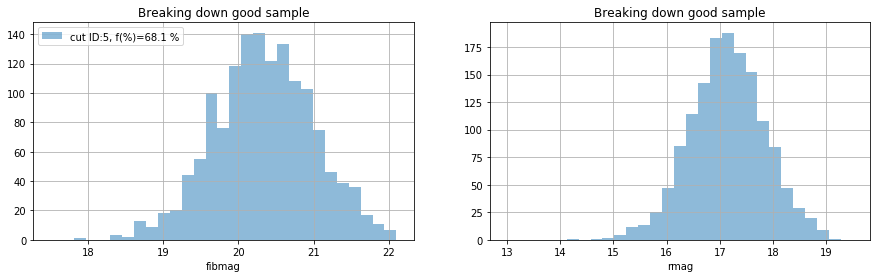

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))

bins_fib = np.linspace(17.5, 22.1, 30)
bins_rmag = np.linspace(13, 19.5, 30)

for i in list(set(BGS['CUTS'][sample_good])):
    MASK = BGS['CUTS'] == i
    print(i, np.sum(MASK & sample_good))
    if np.sum(MASK & sample_good) < 10:
        continue
    if i != '5':
        continue
    ax1.hist(fibmag[(sample_good) & (MASK)], bins=bins_fib, alpha=0.5, label='cut ID:%s, f(%%)=%2.3g %%' %(i, 100*np.sum((sample_good) & (MASK))/np.sum(sample_good)))
    ax2.hist(rmag[(sample_good) & (MASK)], bins=bins_rmag, alpha=0.5, label='%s' %(i))

ax1.set_title('Breaking down good sample')
ax2.set_title('Breaking down good sample')
ax1.grid()
ax2.grid()
ax1.legend()
#ax2.legend()
ax1.set_xlabel('fibmag')
ax2.set_xlabel('rmag')


5 2150
257 4
357 223
57 640
3567 3
2567 5
567 49
56 68
2357 1


Text(0.5, 0, 'rmag')

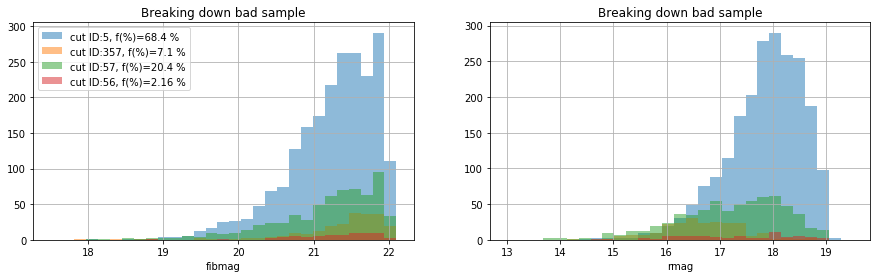

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))

bins_fib = np.linspace(17.5, 22.1, 30)
bins_rmag = np.linspace(13, 19.5, 30)

for i in list(set(BGS['CUTS'][sample_bad])):
    MASK = BGS['CUTS'] == i
    print(i, np.sum(MASK & sample_bad))
    if np.sum(MASK & sample_bad) < 50:
        continue
    ax1.hist(fibmag[(sample_bad) & (MASK)], bins=bins_fib, alpha=0.5, label='cut ID:%s, f(%%)=%2.3g %%' %(i, 100*np.sum((sample_bad) & (MASK))/np.sum(sample_bad)))
    ax2.hist(rmag[(sample_bad) & (MASK)], bins=bins_rmag, alpha=0.5, label='%s' %(i))

ax1.set_title('Breaking down bad sample')
ax2.set_title('Breaking down bad sample')
ax1.grid()
ax2.grid()
ax1.legend()
#ax2.legend()
ax1.set_xlabel('fibmag')
ax2.set_xlabel('rmag')


## Get sample images of cells...

Ngood in cell 00: 458
Nbad in cell 00: 108
------------


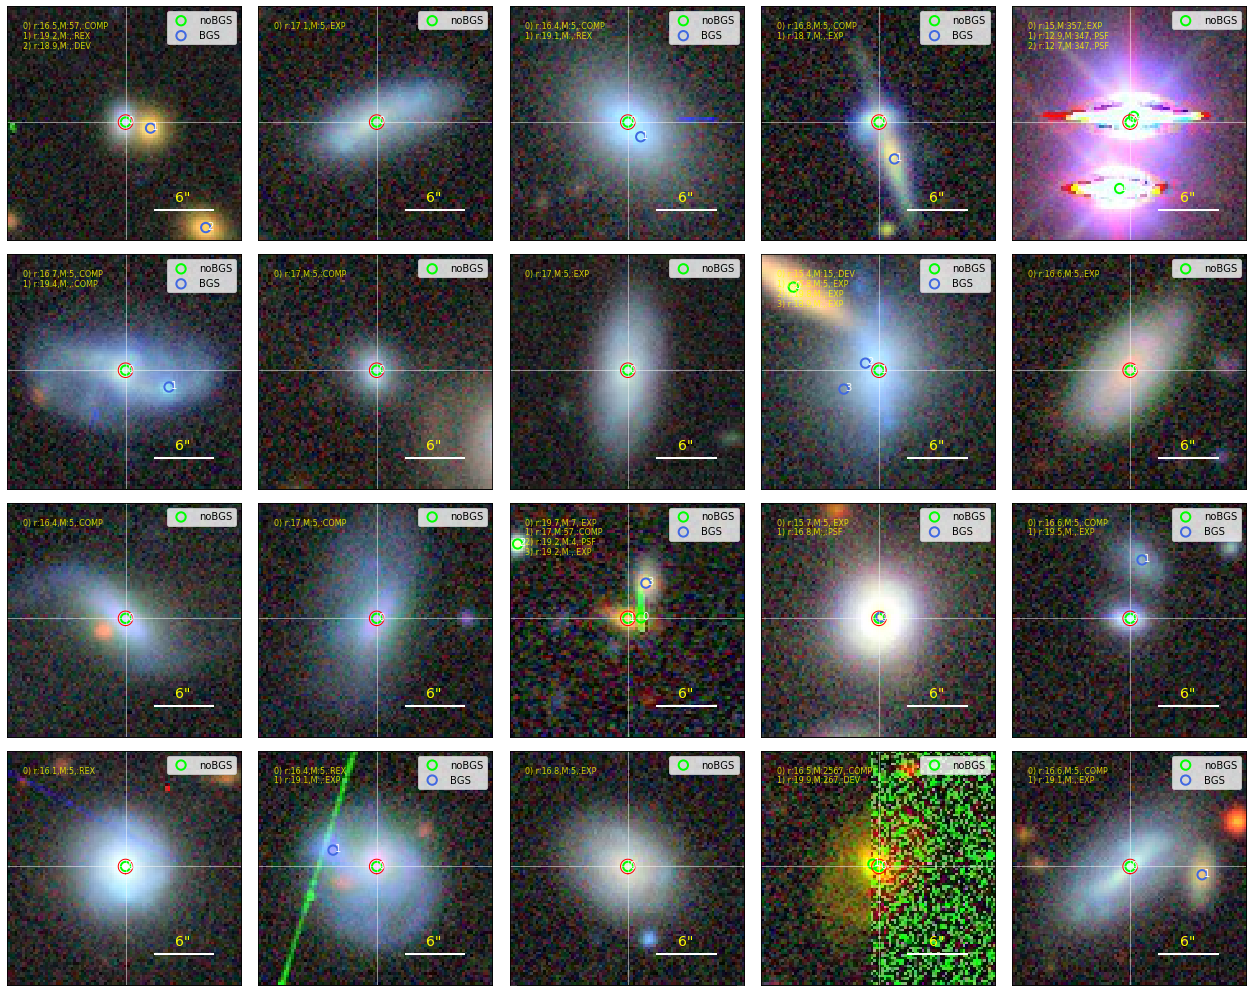

In [31]:
veto = {'noBGS':CUTOUT, 'BGS':~CUTOUT}
info = {'r':np.round(rmag,1),'M':BGS['CUTS'], '':BGS['TYPE']}
#cell_id = ['00', '01', '02', '03', '10', '11', '12', '20', '21', '30']
cell_id = ['00']
for i in cell_id:
    MASK1 = (cells[i]) & (sample_good)
    print('Ngood in cell %s: %d' %(i, np.sum(MASK1)))
    if np.sum(MASK1) > 19:
        postages_circle(coord=[BGS['RA'], BGS['DEC']], centeridx=np.where(MASK1)[0], veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer_dr7, radius=1.5/2./3600, m=16, grid=[4,5], 
                savefile='eyeballing_FMC/images_sample_good_cell_%s' %(i), layer2=None, layer2Mode='separate', isLG=False)
    
    MASK2 = (cells[i]) & (sample_bad)
    print('Nbad in cell %s: %d' %(i, np.sum(MASK2)))
    if np.sum(MASK2) > 19:
        postages_circle(coord=[BGS['RA'], BGS['DEC']], centeridx=np.where(MASK2)[0], veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer_dr7, radius=1.5/2./3600, m=16, grid=[4,5], 
                savefile='eyeballing_FMC/images_sample_bad_cell_%s' %(i), layer2=None, layer2Mode='separate', isLG=False)
    
    print('------------')

# DEF...

In [14]:
def frac_density(pars, pars2, pars3, par_lab, title, log=True, plot='hexbin', limit=None):
    import matplotlib.colors as colors
    
    x = pars[0]
    y = pars[1]
    z = pars[2]
    
    mask = (~np.isnan(y)) & (~np.isinf(y)) & (~np.isnan(x)) & (~np.isinf(x)) 
    if z is not None:
        mask &= (~np.isnan(z)) & (~np.isinf(z))
    #if limit is not None:
    #    mask &= (coord[0] > limit[0]) & (coord[0] < limit[1]) & (coord[1] > limit[2]) & (coord[1] < limit[3])
    print('COMPLETENESS: %g %%' %(np.sum(mask)*100/len(pars[0])))
    x = x[mask]
    y = y[mask]
    if z is not None:
        z = z[mask]
    
    fig = plt.figure(figsize=(8, 6))
    
    left, width = 0.1, 0.85
    bottom, height = 0.1, 0.85

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom, width, 0.3]
    rect_histy = [left, bottom, 0.3, height]
    colbar = [1.1, 0.1, 0.1, 0.85]

    axScatter = plt.axes(rect_scatter)
    axScatter.set_title(title)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    if log:
        bins = 'log'
        zlabel = r'$\log_{10}(W)$'
        norm = colors.LogNorm(vmin=z.min(), vmax=z.max())
    else:
        bins = None
        zlabel = r'$W$'
        norm = None
        
    if z is not None:
        cbaxes = fig.add_axes([1, 0.1, 0.03, 0.8])
        
    if plot == 'hexbin':
        #pos = axScatter.hexbin(x, y, C=z, gridsize=(80,80), cmap='seismic', bins=None, mincnt=1,label=r'test', vmin=-0.2, vmax=1)
        pos = axScatter.hexbin(x, y, C=z, gridsize=(50,50), cmap='seismic', bins=bins, mincnt=1)
        axScatter.set_facecolor('gray')
        fig.colorbar(pos, cax=cbaxes, label=zlabel)
    if plot == 'scatter':
        if z is not None:
            pos = axScatter.scatter(x, y, lw=0.1, c=z, cmap=plt.cm.get_cmap('seismic', 6), norm=norm)
            fig.colorbar(pos, cax=cbaxes, label=zlabel)
        else:
            #axScatter.scatter(x[~CUTOUT[mask]], y[~CUTOUT[mask]], s=1, alpha=0.6, label='inBGS')
            axScatter.scatter(x, y, s=1, alpha=0.6, label='%s' %(par_lab[0]))
            if pars2 is not None:
                axScatter.scatter(pars2[0], pars2[1], marker='*', s=5, color='r', alpha=0.7, label='%s' %(par_lab[1]))
                axScatter.axvline(pars2[0].max(), ls='--', color='orange', label='%2.3g' %(pars2[0].max()))
                #axScatter.axhline(pars2[1].max(), ls='--', color='orange', label='%2.3g' %(pars2[1].max()))
                axScatter.axhline(22.0, ls='--', color='orange', label='%2.3g' %(22.0))
            if pars3 is not None:
                axScatter.scatter(pars3[0], pars3[1], marker='*', s=5, color='green', alpha=0.3, label='%s' %(par_lab[2]))
            
        x2 = np.linspace(13, 20.1, 20)
        axScatter.plot(x2, 2.9 + x2, lw=2, color='k', label='FMC: 2.9 + rmag')
        axScatter.legend()

    axScatter.set_ylabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %('FIBERFLUX_R', 'MW_TRANSMISSION_R'))
    axScatter.set_xlabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %('FLUX_R', 'MW_TRANSMISSION_R'))
    #axScatter.set_xlabel(r'$2.5\times \log_{10}$(%s/%s)' %('FLUX_R', xcol))
    axScatter.grid()
    
    binsx = np.linspace(x.min(), x.max(), 50)
    binsy = np.linspace(y.min(), y.max(), 50)
    
    N1 = axHistx.hist(x, bins=binsx, cumulative=False, log=log, histtype='step', align='mid', color='red', linewidth=1)
    N2 = axHisty.hist(y, bins=binsy, cumulative=False, log=log, histtype='step', align='mid', color='red', linewidth=1, orientation='horizontal')
    
    if limit:
        axScatter.set_xlim(limit[0], limit[1])
        axScatter.set_ylim(limit[2], limit[3])

    axHistx.axis('off')
    axHisty.axis('off')

In [15]:
def self_match(df, MASK, MASK_N, SR):

    if MASK is None:
        MASK = np.ones(len(df), dtype='?')
        
    print('MASK (%s): %2.3g %%' %(MASK_N ,100*np.sum(MASK)/len(df)))

    idx2, idx1, d2d, d_ra, d_dec = search_around(df['RA'][MASK], df['DEC'][MASK], df['RA'][MASK], 
                                             df['DEC'][MASK], search_radius=SR)

    near = d2d > 0
    idx2_near = idx2[near]
    print('In search radius=%d: %2.3g %% out of a total in MASK' %(SR, 100*len(set(idx2_near))/np.sum(MASK)))
    print('In search radius=%d: %2.3g %% out of a total in whole catalogue' %(SR, 100*len(set(idx2_near))/len(df)))
    
    return MASK, MASK_N, SR, idx2_near

In [16]:
def coordtopix2(center, coord, size, scale):
    
    RA_pix = []
    DEC_pix = []
    #print('Center coords entering coordtopix: RA:%.12f, DEC:%.12f' %(center[0], center[1]))
    for i in range(len(coord[0])):
        #print('non-center coords entering coordtopix: RA:%.12f, DEC:%.12f' %(coord[0][i], coord[1][i]))
        #print('NORMAL:non-center coords entering coordtopix: RA:%f, DEC:%f' %(coord[0][i], coord[1][i]))
        #print('output diff center-coords in coordtopix: DRA:%.12f, DDEC:%.12f' %(center[0]-coord[0][i], center[1]-coord[1][i]))
        #print('NORMAL:output diff center-coords in coordtopix: DRA:%f, DDEC:%f' %(center[0]-coord[0][i], center[1]-coord[1][i]))
        print('RA_pix: %f, DEC_pix: %f' %(size/2. + (round(center[0], 12)-round(coord[0][i], 12))*3600./scale,
                                         size/2. + (round(center[1], 12)-round(coord[1][i], 12))*3600./scale))
        print('NORMAL:RA_pix: %f, DEC_pix: %f' %(float(size/2) + (center[0]-coord[0][i])*float(3600/scale),
                                         float(size/2) + (center[1]-coord[1][i])*float(3600/scale)))
        ra_pix = size/2. + (round(center[0], 12)-round(coord[0][i], 12))*3600./scale
        dec_pix = size/2. + (round(center[1], 12)-round(coord[1][i], 12))*3600./scale
        RA_pix.append(ra_pix)
        DEC_pix.append(dec_pix)
    
    return RA_pix, DEC_pix

def coordtopix(center, coord, size, scale):
    
    RA_pix = []
    DEC_pix = []
    for i in range(len(coord[0])):
        d_ra = (center[0]-coord[0][i])*3600
        d_dec = (center[1]-coord[1][i])*3600
        if d_ra > 180*3600:
            d_ra = d_ra - 360.*3600
        elif d_ra < -180*3600:
            d_ra = d_ra + 360.*3600
        else:
            d_ra = d_ra
        d_ra = d_ra * np.cos(coord[1][i]/180*np.pi)
        
        ra_pix = size/2. + d_ra/scale
        dec_pix = size/2. + d_dec/scale
        RA_pix.append(ra_pix)
        DEC_pix.append(dec_pix)
    
    return RA_pix, DEC_pix

def disttopix(D, scale):
    '''
    D must be in arcsec...
    '''
    
    dpix = D/scale
    
    return dpix


def plot_circle_img(coord, centeridx, veto=None, info=None, scale=0.262, scale_unit='pixscale', layer='decals-dr7', 
                    radius=None, m=4, ax=plt, isLG=None):
    
    from astropy.utils.data import download_file  #import file from URL
    from matplotlib.ticker import NullFormatter
    from matplotlib.patches import Ellipse
        
    RAidx = coord[0][centeridx] #centre
    DECidx = coord[1][centeridx] #centre
        
    if isLG:
        print('Central coords in postage: RA:%.12f, DEC:%.12f, Cidx:%d, rad:%2.2g' %(RAidx, DECidx, centeridx, radius[0]*3600))
        ramin, ramax = RAidx-m*radius[0], RAidx+m*radius[0]
        decmin, decmax = DECidx-m*radius[0], DECidx+m*radius[0]
        #postage image sizes
        boxsize = 2*m*radius[0]*3600
        size = int(round(boxsize/scale))
        rad_pix = disttopix(radius[0]*3600., scale=scale)
        major_pix = disttopix(D=radius[0]*3600, scale=scale)
        minor_pix = disttopix(D=radius[1]*3600, scale=scale)
    
        ellipse = Ellipse((size/2., size/2.), width=2*major_pix, height=2*minor_pix, angle=radius[2],
                       edgecolor='r', fc='None', lw=2, ls='-')
    else:
        #print('Central coords in postage: RA:%.12f, DEC:%.12f, Cidx:%d, rad:%2.2g' %(RAidx, DECidx, centeridx, radius*3600))
        ramin, ramax = RAidx-m*radius, RAidx+m*radius
        decmin, decmax = DECidx-m*radius, DECidx+m*radius
        #postage image sizes
        boxsize = 2*m*radius*3600
        size = int(round(boxsize/scale))
        rad_pix = disttopix(radius*3600., scale=scale)
        angle_array = np.linspace(0, 2*np.pi, 240)
        x = size/2 - rad_pix * np.sin(angle_array)
        y = size/2 - rad_pix * np.cos(angle_array)
        #x = RAidx - radius * np.sin(angle_array)
        #y = DECidx - radius * np.cos(angle_array)
        #x_pix, y_pix = coordtopix(center=[RAidx, DECidx], coord=[x, y], size=size, scale=scale)
    
    mask = (coord[0] > ramin) & (coord[0] < ramax) & (coord[1] > decmin) & (coord[1] < decmax)
    #print('pixels:',size)
    scale_l = np.array([[size*5/8, size*7/8], [size*1/8, size*1/8]])
    
    colours = ['lime', 'royalblue', 'purple', 'orange']

    de_cutout_url = 'http://legacysurvey.org/viewer-dev/jpeg-cutout/?ra=%.12f&dec=%.12f&%s=%g&layer=%s&size=%g' % (RAidx, DECidx, scale_unit, scale, layer, size)
    img = plt.imread(download_file(de_cutout_url,cache=True,show_progress=False,timeout=120))
    if ax == plt:
        fig = plt.figure(figsize=(6,6))
    else:
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    ax.imshow(img, origin='lower', aspect='equal')
    ax.axvline(size/2, lw=1, color='white', alpha=0.5)
    ax.axhline(size/2, lw=1, color='white', alpha=0.5)
    ax.plot(scale_l[0], scale_l[1], lw=2, color='white')
    ax.text(size*5.7/8, size*1.3/8, '%i" ' %(boxsize/4), color='yellow', size=14)
    if isLG:
        ax1 = plt.gca()
        ax1.add_patch(ellipse)
    else:
        #ax.plot(x_pix, y_pix, 'red', lw=1)
        ax.plot(x, y, 'red', lw=1)
    
    if veto is not None:
        rapix = []
        decpix = []
        IDX1 = []
        j= 0
        for i in veto:
            if np.sum((veto[i]) & (mask)) < 1:
                j += 1
                continue
                
            rav = coord[0][(veto[i]) & (mask)]
            decv = coord[1][(veto[i]) & (mask)]
            #print('All coords in postage: RA:%.12f, DEC:%.12f' %(rav[1], decv[1]))
            ravpix, decvpix = coordtopix(center=[RAidx, DECidx], coord=[rav, decv], size=size, scale=scale)
            ax.scatter(ravpix, decvpix, marker='.', s = 350, facecolors='none', edgecolors=colours[j], lw=2, label='%s' %(i))
            for i2 in range(len(ravpix)):
                rapix.append(ravpix[i2])
                decpix.append(decvpix[i2])
                IDX1.append(list(np.where((veto[i]) & (mask))[0])[i2])
            j += 1
            
        v0 = np.zeros(len(veto[list(veto.keys())[0]]), dtype='?')
        for i,j in enumerate(list(veto.keys())):
            v0 |= veto[j]
        v0m = (~v0) & (mask)
        if np.sum(v0m) > 0:
            rav1 = coord[0][v0m]
            decv1 = coord[1][v0m]
            ravpix1, decvpix1 = coordtopix(center=[RAidx, DECidx], coord=[rav1, decv1], size=size, scale=scale)
            ax.scatter(ravpix1, decvpix1, marker='.', s = 300, facecolors='none', edgecolors='red', lw=2, label='other')
            for i1 in range(len(ravpix1)):
                rapix.append(ravpix1[i1])
                decpix.append(decvpix1[i1])
                IDX1.append(list(np.where(v0m)[0])[i1])
        
        if info is not None:
            j2 = 9*size/10
            for k in range(len(rapix)):
                ax.text(rapix[k]+rad_pix*0.20, decpix[k]-rad_pix*0.20, '%s' %(k), color='white')
                txt = []
                for l in info:
                    val = info[l][IDX1[k]]
                    if isinstance(val, (float, np.float32, np.float64)):
                        txti = '%s:%2.4g' %(l,val)
                    elif isinstance(val, str):
                        txti = '%s:%s' %(l,val)
                    elif isinstance(val, int):
                        txti = '%s:%i' %(l,val)
                    txt.append(txti)
                ax.text(size/16,j2, '%i) %s' %(k, ','.join(txt)), fontsize=8,color='yellow', alpha=0.8)
                j2 -= size/24
                
        ax.legend(loc = 'upper right')
    else:
        rav = coord[0][mask]
        decv = coord[1][mask]
        rapix, decpix = coordtopix(center=[RAidx, DECidx], coord=[rav, decv], size=size, scale=scale)
        ax.scatter(rapix, decpix, marker='.', s = 300, facecolors='none', edgecolors='lime', lw=2)
        
    if ax == plt:
        return fig
    

def postages_circle(coord, centeridx, veto=None, info=None, scale=0.262, scale_unit='pixscale', layer='decals-dr7', 
                    radius=None, m=4, grid=None, savefile=None, layer2=None, layer2Mode='merge', isLG=False):
    '''
    Create a postage image (or a table of images) from selected object(s).
    
    coord::class:`2D-array`
        RA, DEC coordinates of catalogue/dataframe of interest.
    centeridx::class:`array or int`
        Index(es) of the object(s) that will be at the centre of the postage(s). The index have to follow the catalogue/dataframe indexes.
    veto::class:`dictionary-boolean-array`
        Dictionary-array containing boolean-arrays that will be shown in the postages as labels. These need to have same lenght as coord and same indexes.
    info::class:`dictionary-boolean-array`    
        
        '''
    
    import matplotlib.gridspec as gridspec
    import random

    if grid is not None:
        
        if not isinstance(centeridx, np.ndarray):
            raise ValueError('If using grid use a proper list of index at centeridx...')
            
        rows, cols = grid[0], grid[1]
        if (layer2 is not None) & (layer2Mode == 'merge'):
            figsize = (4.5*cols, 4.5*rows*2)
            gs = gridspec.GridSpec(rows*2, cols)
        else:
            figsize = (4.5*cols, 4.5*rows)
            gs = gridspec.GridSpec(rows, cols)
            
        gs.update(wspace=0.001, hspace=0.06)
        idx_list = random.sample(list(centeridx), rows*cols)

        fig = plt.figure(num=1, figsize=figsize)
        ax = []
        
        for i, j in enumerate(idx_list):
            
            if isinstance(radius, np.ndarray):
                radius2 = radius[j]
                #print(j, radius2*3600)
            else:
                radius2 = radius
                
            if (layer2 is not None) & (layer2Mode == 'merge'):
                row = (i // cols)*2
            else:
                row = (i // cols)
            col = i % cols

            ax.append(fig.add_subplot(gs[row, col]))
            plot_circle_img(coord=coord, centeridx=j, veto=veto, info=info, scale=scale, 
                scale_unit=scale_unit, layer=layer, radius=radius2, m=m, ax=ax[-1], isLG=isLG)
            
            if (layer2 is not None) & (layer2Mode == 'merge'):
                ax.append(fig.add_subplot(gs[row+1, col]))
                plot_circle_img(coord=coord, centeridx=j, veto=veto, info=info, scale=scale, 
                        scale_unit=scale_unit, layer=layer2, radius=radius2, m=m, ax=ax[-1], isLG=isLG)
                    
            if (layer2 is not None) & (layer2Mode == 'separate'):
                fig2 = plt.figure(num=2, figsize=figsize)
                ax2 = []
                ax2.append(fig2.add_subplot(gs[row, col]))
                plot_circle_img(coord=coord, centeridx=j, veto=veto, info=info, scale=scale, 
                        scale_unit=scale_unit, layer=layer2, radius=radius2, m=m, ax=ax2[-1], isLG=isLG)
            
    else:
        if isinstance(centeridx, np.ndarray):
            raise ValueError('If Not using grid do not use a list of index at centeridx...')
            
        if (isinstance(radius, np.ndarray)) & (~isLG):
            raise ValueError('If Not using grid do not use a list of radius...')
        
        fig = plot_circle_img(coord=coord, centeridx=centeridx, veto=veto, info=info, scale=scale, 
                scale_unit=scale_unit, layer=layer, radius=radius, m=m, ax=plt, isLG=isLG)
    
    if savefile is not None:
        if (layer2 is not None) & (layer2Mode == 'separate'):
            fig.savefig(savefile +'.png', bbox_inches = 'tight', pad_inches = 0)
            fig2.savefig(savefile + '_%s' %(layer2[-5:]) + '.png', bbox_inches = 'tight', pad_inches = 0)
        elif (layer2 is not None) & (layer2Mode == 'merge'):
            fig.savefig(savefile + '_%s' %(layer2[-5:]) + '.png', bbox_inches = 'tight', pad_inches = 0)
        else:
            fig.savefig(savefile +'.png', bbox_inches = 'tight', pad_inches = 0)
        
    

In [17]:
#Rongpu's circ radii
rongpuLRG_radii = [[4.0, 210.],[4.5, 210.], [5.5, 200.], [6.25, 150.], [6.75, 125.],
                   [7.25, 120.], [7.75, 110.], [8.25, 100.], [8.75,  75.], [9.25,  60.],
                   [9.75,  55.], [ 10.25,  50.], [ 10.75,  48.], [ 11.25,  40.], [ 11.75,  37.], 
                   [ 12.25,  25.], [ 12.75,  20.], [ 13.25,  18.], [ 13.75,  16.], [ 14.25,  12.], 
                   [ 14.75,  11.], [ 15.25,  11.], [ 15.75,  10.]]

#Rongpu's length radii (diff spikes)
rongpuLRG_length_radii = [[4.0, 600.], [4.5, 600.], [5.5, 600.], [6.25, 540.], [6.75, 520.], [7.25, 500.], 
                   [7.75, 320.], [8.25, 300.], [8.75, 290.], [9.25, 160.], [9.75, 150.], [ 10.25, 140.],
                   [ 10.75, 130.], [ 11.25, 130.], [ 11.75, 100.], [ 12.25, 60.], [ 12.75, 40.], [ 13., 40.]]

#Rongpu's widht radii (diff spikes)
rongpuLRG_widht_radii = [[8., 25.], [13., 16.]]

#kyle_radii's = rongpuLRG_radii's/np.sqrt(2)
kyle_radii = []
for i in range(len(rongpuLRG_radii)):
    kyle_radii.append([rongpuLRG_radii[i][0], rongpuLRG_radii[i][1]/np.sqrt(2)])

kyle_length_radii = []
for i in range(len(rongpuLRG_length_radii)):
    kyle_length_radii.append([rongpuLRG_length_radii[i][0], rongpuLRG_length_radii[i][1]/np.sqrt(2)])

kyle_widht_radii = []
for i in range(len(rongpuLRG_widht_radii)):
    kyle_widht_radii.append([rongpuLRG_widht_radii[i][0], rongpuLRG_widht_radii[i][1]/np.sqrt(2)])
    
#TWOMASS radii
twomass_radii = [[9.5,100], [10.5, 80], [11.5, 70], [12.5, 50], [13.5, 30], 
                 [14.5, 20], [15.5, 10], [16.5, 5]]

#LSLGA radii
LSLGA_radii = [[9.5,100], [10.5, 90], [11.5, 80], [12.5, 70], [13.5, 60], 
               [14.5, 50], [15.5, 35], [16.5, 25], [17.5, 15], [17.5, 10], [18, 8]]

#Dustin_radii's
mag = np.linspace(0, 20, 50)
Dustin_MS_radii = []
for i,j in enumerate(mag):
    Dustin_MS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])